# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numba import njit, cuda

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Subsampling images of fashion mnist

As we need to create a look up table we need to reduce the input neuron size. Thus, we will need to sample our images

In [197]:
#creating the sample indexes
skipsinIndexes = 2
newShape = 28//skipsinIndexes
Y, X = np.meshgrid([i for i in range(0, 28, skipsinIndexes)], [i for i in range(0, 28, skipsinIndexes)])
X, Y

(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
        [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
        [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24],
        [26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]]),
 array([[ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26],
        

In [198]:
sampled_x_train = np.zeros(((newShape)**2, x_train.shape[1]))
sampled_x_val = np.zeros(((newShape)**2, x_val.shape[1]))
for i in range(x_train.shape[1]):
    samp = x_train[:, i].reshape((28, -1))
    sampled_x_train[:, i] = samp[X, Y].flatten()
for i in range(x_val.shape[1]):
    samp = x_val[:, i].reshape((28, -1))
    sampled_x_val[:, i] = samp[X, Y].flatten()

Text(0.5, 1.0, 'Subsampled version of the image with samples every 2 indices')

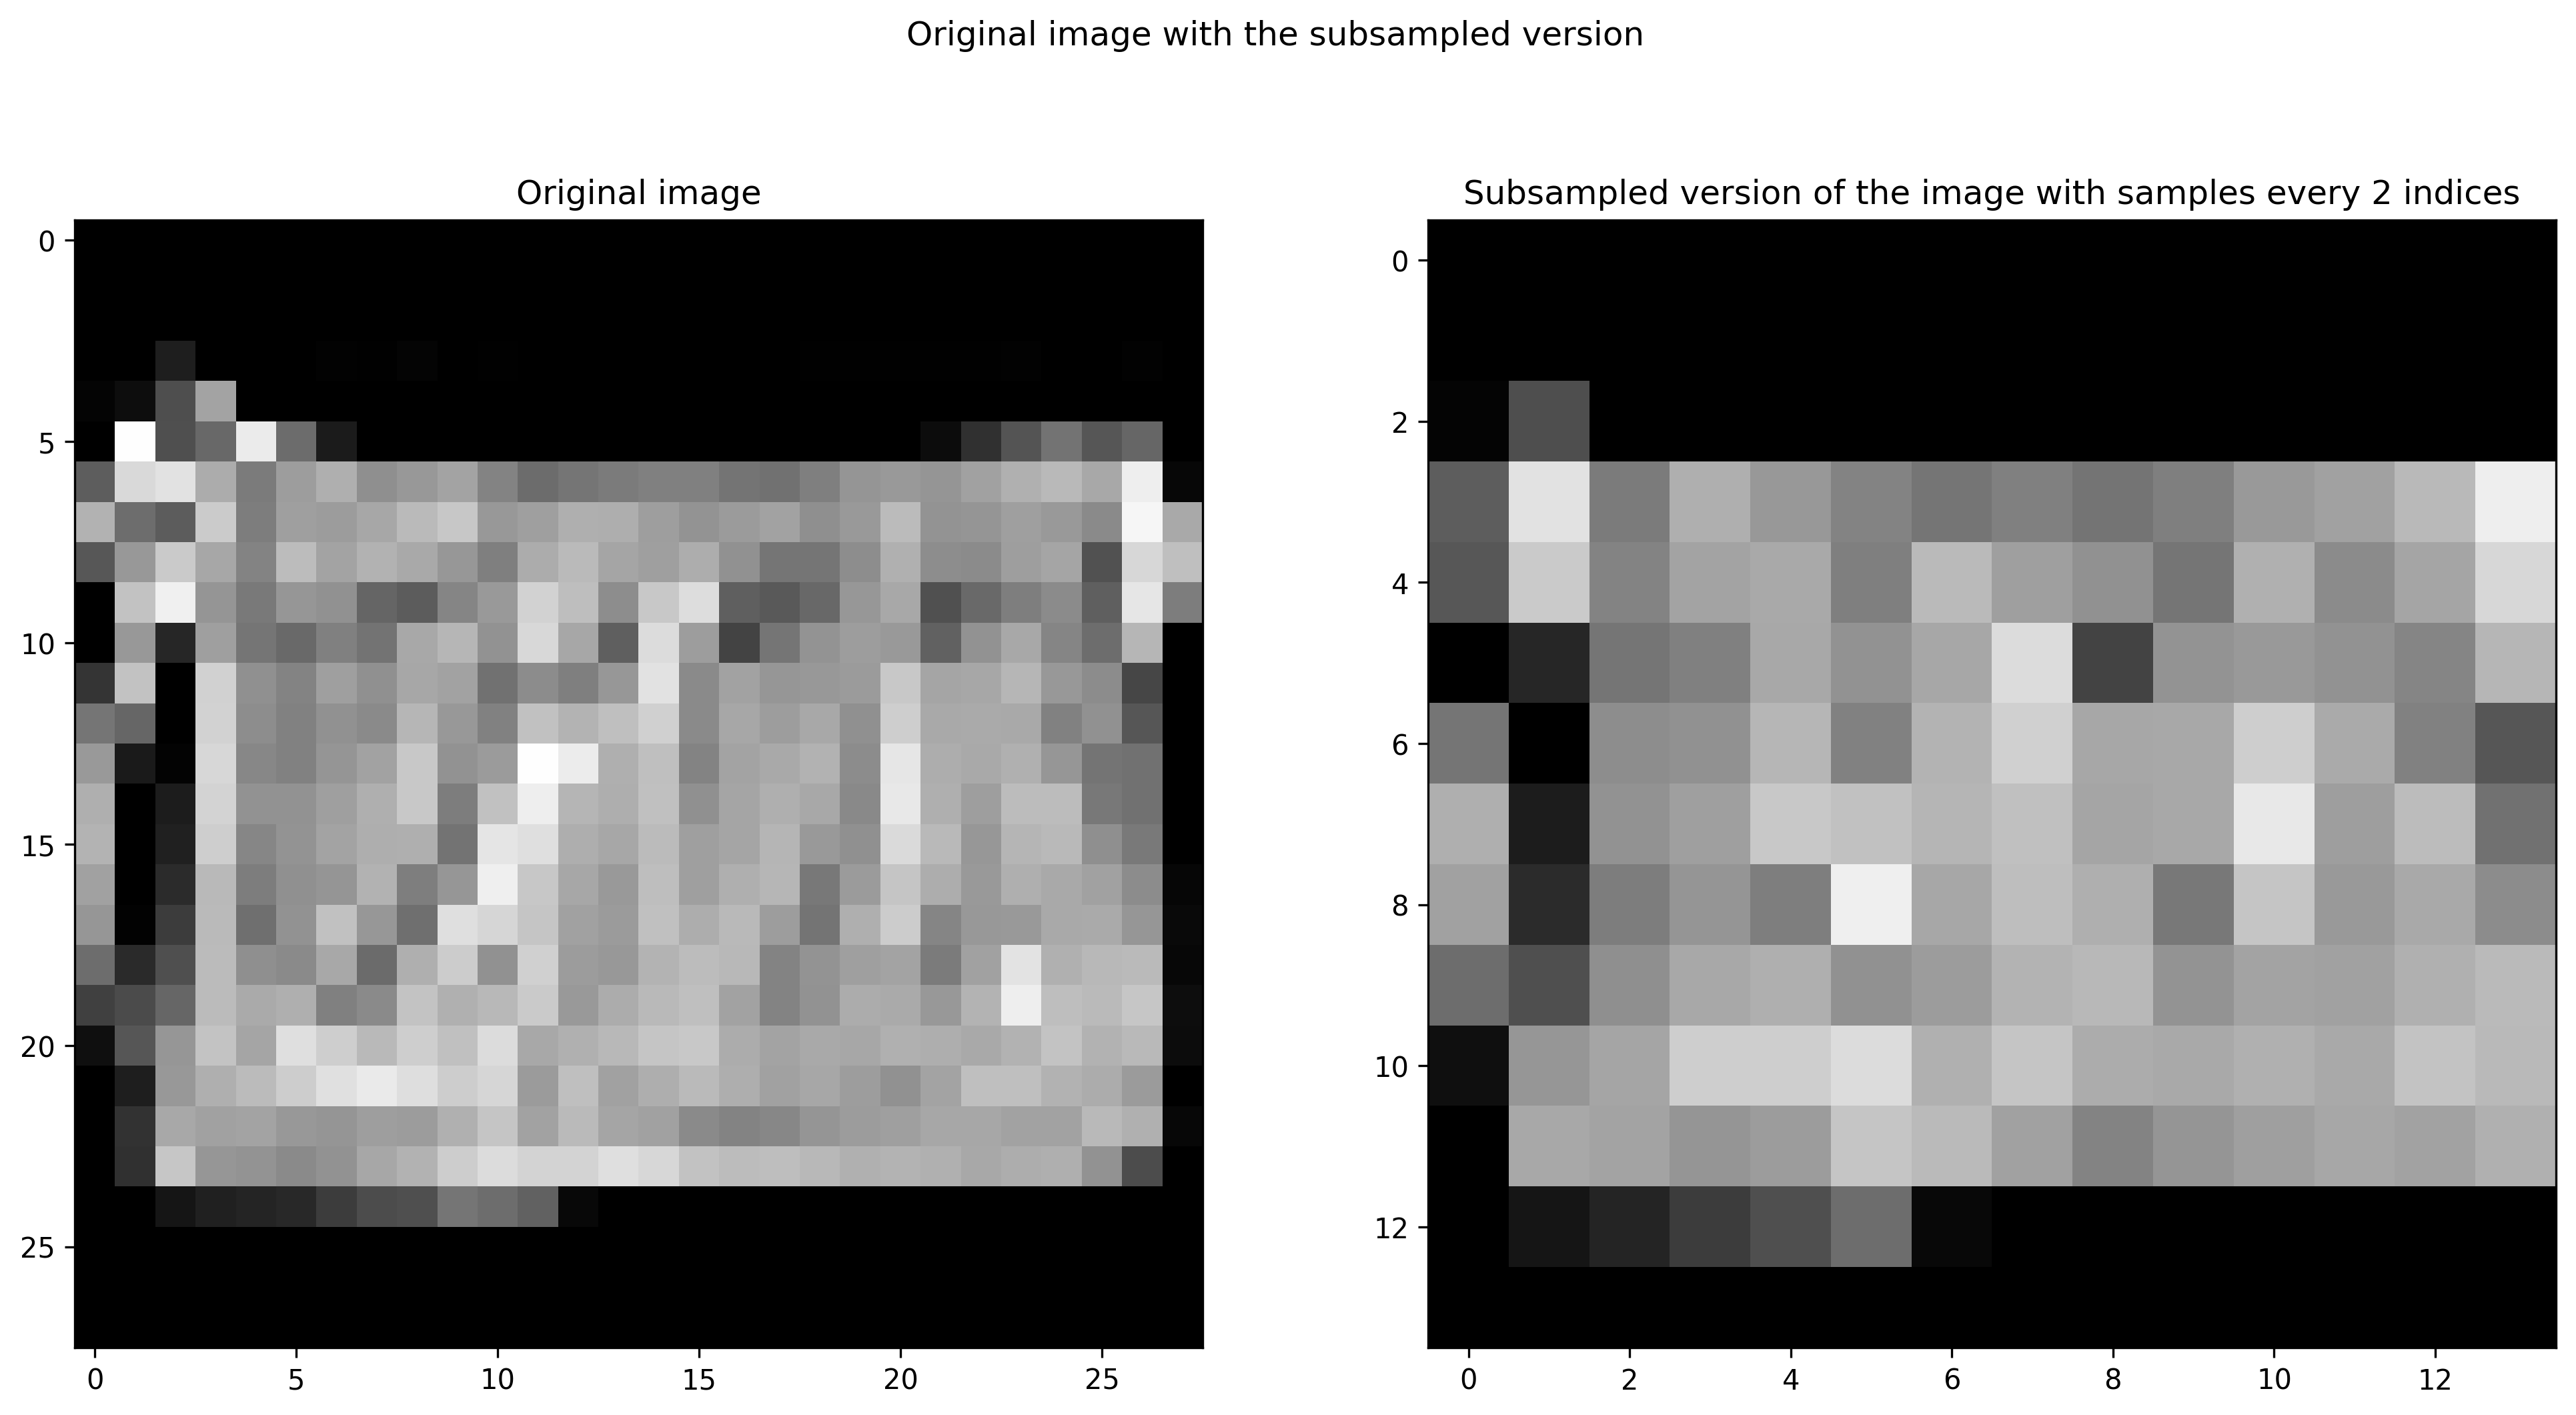

In [201]:
plt.figure(figsize = (16, 8))
plt.gcf().set_dpi(300)
ind = np.random.randint(0, x_train.shape[1])
plt.suptitle("Original image with the subsampled version")
plt.subplot(121)
plt.imshow(x_train[:, ind].reshape(28, -1), cmap = 'gray', vmin =0, vmax = 1)
plt.title("Original image")
plt.subplot(122)
plt.imshow(sampled_x_train[:, ind].reshape(newShape, -1), cmap = 'gray', vmin =0, vmax = 1)
plt.title(f"Subsampled version of the image with samples every {skipsinIndexes} indices")

# Training software BP with new subsampled version of MNIST

In [191]:
def params_init(newShape, midLayerSize, seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(midLayerSize,newShape) - 0.5
  b1 = np.random.rand(midLayerSize,1) - 0.5
  W2 = np.random.rand(10,midLayerSize) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

In [143]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [144]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre + 10e-16)), axis = 0)
  return loss

In [145]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

In [146]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

In [147]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [192]:
def batch_grad_descent(X,Y,iter, lr, midLayerSize, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}
  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = None)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(1): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      #X1, Y1 = shuffle(X[:, j*15: (j+1)*15].T,Y[j*15: (j+1)*15]) #shuffle each batch
      #X1 = X1.T #take transpose to match the sizes
      X1, Y1 = X, Y

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(sampled_x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score} Val loss: {np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      # plt.figure()
      # plt.hist(W1.flatten())

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [209]:
_, _, _, _, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(sampled_x_train,y_train,iter=200, lr=0.05,midLayerSize = 100, print_op=20);

Params Initialised
Iteration: 20
Train accuracy: 47.474603174603175
Val accuracy: 47.82857142857143 Val loss: 10485.338670186791
Iteration: 40
Train accuracy: 59.22063492063492
Val accuracy: 58.58571428571429 Val loss: 8212.170184092724
Iteration: 60
Train accuracy: 64.26666666666667
Val accuracy: 63.25714285714285 Val loss: 7231.21275145176
Iteration: 80
Train accuracy: 67.17142857142858
Val accuracy: 66.51428571428572 Val loss: 6663.113539455517
Iteration: 100
Train accuracy: 68.9920634920635
Val accuracy: 68.22857142857143 Val loss: 6281.906391819059
Iteration: 120
Train accuracy: 70.35396825396826
Val accuracy: 69.5 Val loss: 6001.46427192615
Iteration: 140
Train accuracy: 71.38253968253969
Val accuracy: 70.61428571428571 Val loss: 5782.584505483424
Iteration: 160
Train accuracy: 72.24603174603175
Val accuracy: 71.54285714285714 Val loss: 5604.959930884073
Iteration: 180
Train accuracy: 72.94285714285714
Val accuracy: 72.17142857142858 Val loss: 5456.397633972585
Iteration: 200
Tra

### Generic functions related to variability

In [167]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [168]:
def initMosParam(shape, mu, sigma, vDD, precision, k=100):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/k
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    Vth[Vth<=0] = 10e-10

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((0 - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    #Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-8, size = sizeI)#no negative value
    iOff = I0Off * np.exp((0 - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)
    return (iOn, iOnNominal, iOff)

In [169]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [170]:
def createLookUpTable2d(weightArray, currents, precision, step, discreteSteps, wRange):
    dis = [(-1)*i for i in discreteSteps[::-1]] + discreteSteps
    finalLookUp = np.zeros((weightArray.shape[0], weightArray.shape[1], len(dis)))
    k = 0
    for i in dis:
        maskee = np.ones_like(weightArray, dtype = float)*i
        maskeeTransformed  = weightTransformWithVariability(maskee, currents, precision, step, discreteSteps, wRange)
        finalLookUp[:, :, k] += maskeeTransformed
        k +=1
    return finalLookUp 

In [171]:
def nearest(lookUpDiff, weightUpdate):
    # W1new = W1  + dW1
    # we want to compare and find W1new such that W1new-(W1+dW1) has least deviation!!!
    # We look at L1 error and take the minimum of this!
    idx = np.argmin(np.abs(lookUpDiff - weightUpdate[:,:,None]), axis = 2)
    return idx

In [172]:
def findNextWeight(lookUp, lookUpDiff, weightUpdate):
    idx = np.indices(nearest(lookUpDiff, weightUpdate).shape)
    #discrete lookup needs to be used
    return lookUp[idx[0],idx[1],nearest(lookUpDiff, weightUpdate)]

In [173]:
def findNextState(disArr, lookUpDiff, weightUpdate):
    return disArr[nearest(lookUpDiff, weightUpdate)]

In [202]:
mu = 0.7
sigma = 0.01
onoff = 10000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps

In [206]:
W1, b1, W2, b2 = params_init(49, 100, None)
W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
b1 = roundArbitrary(b1, step, wRange)
W2 = roundArbitrary(W2, step, wRange)
b2 = roundArbitrary(b2, step, wRange)

disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)

W1Currents = initMosParam((100, 49), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
b1Currents = initMosParam((100, 1), mu, sigma, vDD, precision, k =onoff)
W2Currents = initMosParam((10, 100) ,mu, sigma, vDD, precision, k =onoff)
b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)

Params Initialised


In [207]:
W1lookUp = createLookUpTable2d(W1, W1Currents, precision, step, discreteSteps, wRange)
b1lookUp = createLookUpTable2d(b1, b1Currents, precision, step, discreteSteps, wRange)
W2lookUp = createLookUpTable2d(W2, W2Currents, precision, step, discreteSteps, wRange)
b2lookUp = createLookUpTable2d(b2, b2Currents, precision, step, discreteSteps, wRange)

In [208]:
W1lookUp.shape

(100, 49, 8190)